**Décimo Trabalho da disciplina RNA e Deep Learning**

**Discente: Valéria Cristina A. R. de Figueredo**

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil.
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [52]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [53]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

<ipython-input-53-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [54]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

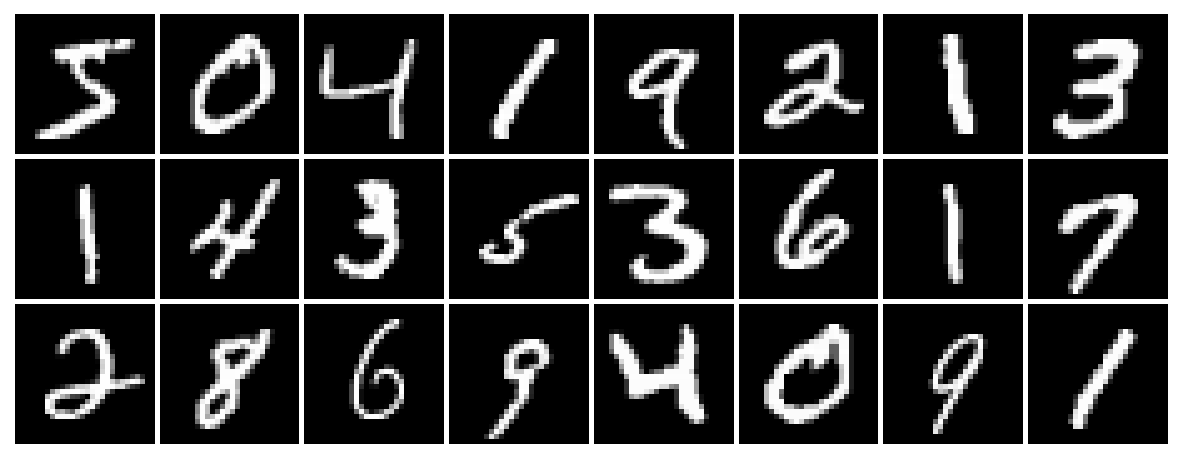

In [55]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


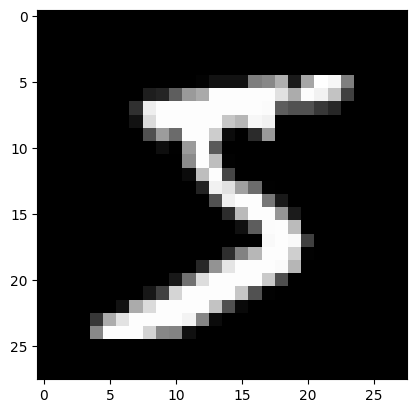

In [56]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [57]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [58]:
## TODO

# Função de previsão
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)
    return predicts.data

# Definir o número de amostras para o teste (100 amostras)
n_samples_test = 1000

# Testando com as primeiras 'n_samples_test' amostras
y_pred = predict(model, x_train[:n_samples_test].view(-1, 28*28))

# Calcular a acurácia com as poucas amostras
accuracy = (y_pred.numpy() == y_train[:n_samples_test].numpy()).mean()

print('Accuracy (com poucas amostras):', accuracy)

Accuracy (com poucas amostras): 0.083


## Treinamento

### Inicialização dos parâmetros

In [59]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [60]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-z74890ry
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-z74890ry
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


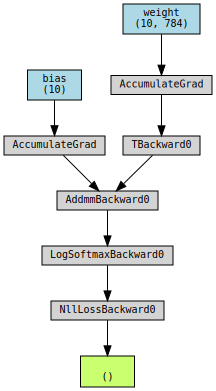

In [61]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [62]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [63]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
print('Final loss:', loss.data)

Final loss: tensor(1.1008)


### Visualizando gráfico de perda durante o treinamento

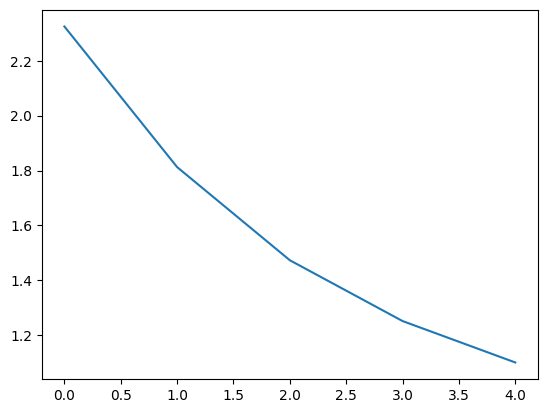

In [65]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [66]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.813


### Matriz de confusão com dados de treinamento e teste

In [67]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,94,0,3,2,2,5,3,1,0,2
1,0,108,11,1,1,3,3,4,8,1
2,1,0,71,0,0,1,0,1,2,0
3,0,1,1,80,1,17,0,0,9,2
4,0,0,2,0,90,5,0,2,0,6
5,0,1,0,2,0,47,1,0,0,1
6,2,1,2,2,4,4,86,0,3,1
7,0,1,6,3,1,1,1,105,0,15
8,0,4,3,2,0,6,0,0,63,3


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


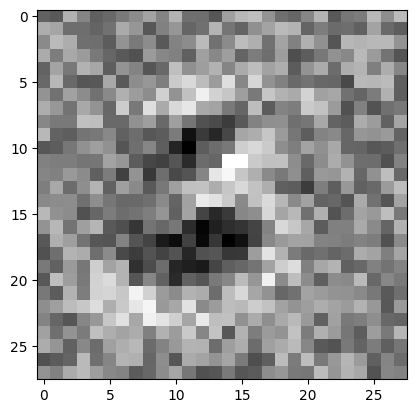

In [68]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

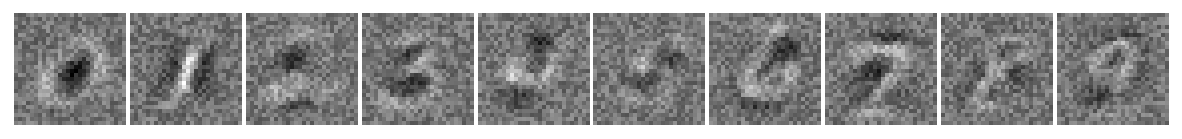

In [69]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Época 1/5 - Perda: 0.9923 - Acurácia: 0.8130
Época 2/5 - Perda: 0.9111 - Acurácia: 0.8250
Época 3/5 - Perda: 0.8482 - Acurácia: 0.8410
Época 4/5 - Perda: 0.7977 - Acurácia: 0.8510
Época 5/5 - Perda: 0.7562 - Acurácia: 0.8540


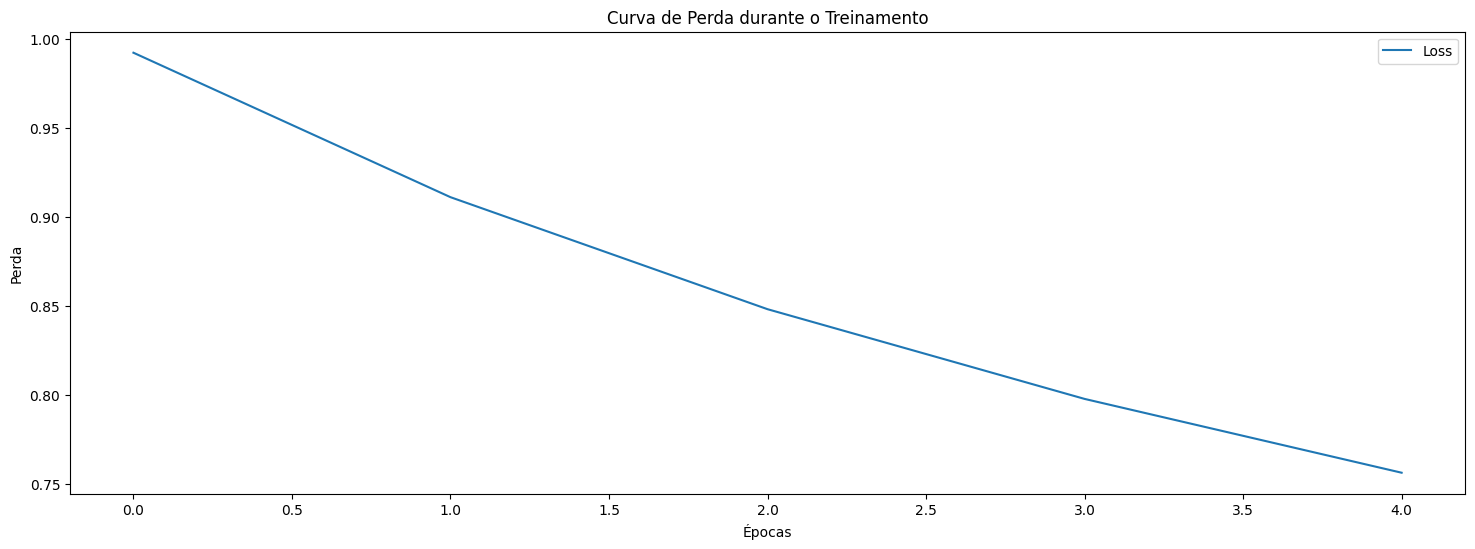

Acurácia final: 0.8590


In [70]:
#Primeira Questão

# Inicializar a figura para plotagem
fig = plt.figure(figsize=(18, 6))

losses = []
zs = []

# Número de épocas
epochs = 5

try:
    for epoch in range(epochs):
        # Transformar a entrada para uma dimensão (flatten)
        inputs = Variable(x_train.view(-1, 28 * 28))

        # Passar os dados pela rede (forward pass)
        outputs = model(inputs)

        # Armazenar a saída de uma amostra
        zs.append(outputs[1].detach().numpy())

        # Calcular a perda (cross-entropy loss)
        loss = criterion(outputs, Variable(y_train))

        # Zero do gradiente, backpropagation e ajuste dos parâmetros
        optimizer.zero_grad()
        loss.backward()  # Cálculo do gradiente
        optimizer.step()  # Atualiza os pesos com o gradiente descendente

        losses.append(loss.data)

        # Realizar a previsão (cálculo de classe predita)
        _, predicts = torch.max(outputs, 1)
        y_pred = predicts.data

        # Calcular a acurácia da época
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        # Exibir informações da época
        print(f"Época {epoch+1}/{epochs} - Perda: {loss.item():.4f} - Acurácia: {accuracy:.4f}")

except KeyboardInterrupt:
    pass

# Plotar a curva da perda ao longo das épocas
plt.plot(losses, label="Loss")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.title("Curva de Perda durante o Treinamento")
plt.legend()
plt.show()

# Se quiser ver a acurácia final em todas as amostras
y_pred = predict(model, x_train.view(-1, 28 * 28))
accuracy_final = (y_pred.numpy() == y_train.numpy()).mean()
print(f"Acurácia final: {accuracy_final:.4f}")

In [71]:
# Segunda Questão
# Inicializar a figura para plotagem
fig = plt.figure(figsize=(18, 6))

losses = []
zs = []

# Número de épocas
epochs = 5

try:
    for epoch in range(epochs):
        # Transformar a entrada para uma dimensão (flatten)
        inputs = Variable(x_train.view(-1, 28 * 28))

        # Passar os dados pela rede (forward pass)
        outputs = model(inputs)

        # Armazenar a saída de uma amostra (como exemplo)
        zs.append(outputs[1].detach().numpy())

        # Calcular a perda (cross-entropy loss)
        loss = criterion(outputs, Variable(y_train))

        # Zero do gradiente, backpropagation e ajuste dos parâmetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)

        # Realizar a previsão (cálculo de classe predita)
        _, predicts = torch.max(outputs, 1)
        y_pred = predicts.data

        # Visualizar os gradientes para a classe 4
        class_4_gradients = model.weight.grad[4].detach().numpy()  # Gradientes para a classe 4
        print(f"Gradientes da classe 4 na época {epoch+1}: {class_4_gradients[10:]}...")

except KeyboardInterrupt:
    pass


Gradientes da classe 4 na época 1: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.11256447e-05  1.30978995e-04  0.00000000e+00  4.27013802e-05
  1.73486420e-04  2.21733761e-04  1.56317576e-04  2.05398188e-04
  1.01001751e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.24182106e-04  5.95447142e-04  3.95274896e-04  3.396

<Figure size 1800x600 with 0 Axes>

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

Considerando esses dados, amostras de treinamento: 60000, dimensões dos dados das imagens:    torch.Size([60000, 28, 28]), model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida
e n_samples_train = 1000, serão realizadas as seguintes análises:

**1.shape da matriz de entrada na rede**

Shape da matriz de entrada: (1000, 784)

* 1000 amostras de entrada e cada amostra tem 784 características- 28x28 (pixels da imagem achatados).

**2.shape da matriz de saída na rede**

Shape da matriz de saída: (1000, 10)

Para cada uma das 1000 amostras, a rede retorna 10 valores, correspondendo às probabilidades dos 10 dígitos possíveis (0 a 9).

**3.Número total de parâmetros da rede, incluindo o bias**

**Parâmetros de peso:**

Cada entrada (784) está conectada a cada neurônio de saída (10). Portanto, o número de parâmetros de peso é: 784 x 10 = 7840

**Parâmetros de bias:**

10 - cada neurônio de saída tem um parâmetro de bias.

**Número total de parâmetros da rede**

Número total de parâmetros: 7840 + 10 =**7850**




# Aprendizados


Este notebook realizou a classificação de dígitos manuscritos utilizando o dataset MNIST. Os 60 mil dados possuem muitos atributos: 28 x28 pixels, de modo que foi necessário pegar uma amostra(sample).

Nesse contexto, foi realizado o carregamento de dados do MNist de forma completa, outro carregamento mas dessa vez com uma seleção de 1000 elementos e normalização. Também ocorreu a visualização de dados e a visualização de imagem com o matplotlib.

Foi testado um predict com poucas amostras e ocorreu o treinamento, com  a inicialização de parâmetros, visualização do grafo computacional da perda (loss), o laço de treinamento dos pesos e a visualização gráfica de perda durante o treinamento.

Também ocorreu a avaliação, com a determinação da acurácia e a matriz de confusão. E a visualização dos pesos de todas as classes, bem como o diagrama de regressão softmax com visualização dos pesos w.

Sobre as atividades, foram inscritos códigos no laço do treinamento para que no final de cada época fosse impresso o número da época, a perda, a acurácia e a visualização dos valores dos gradientes referentes à classe do dígito 4.

Por fim, foram analisados o shape da matriz de entrada e saída na rede, bem como o número total de parâmetros da rede, incluindo o bias.